# Implementation of LPD with ODL and PyTorch


References:

https://towardsdatascience.com/cook-your-first-u-net-in-pytorch-b3297a844cf3

https://medium.com/analytics-vidhya/unet-implementation-in-pytorch-idiot-developer-da40d955f201

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

You need to run this script first to train the LPD network and generate a .pth file that saves the parameters of the model

The codes train the LPD network on GPU by default for better performance

In [1]:
import torch
import torch.nn as nn
import odl
import numpy as np
import matplotlib.pyplot as plt
from LPD import LPD

In [2]:
# Define ODL oprators
reco_space = odl.uniform_discr(
    min_pt=[-20, -20], max_pt=[20, 20], shape=[256, 256],
    dtype='float32')
angle_partition = odl.uniform_partition(0, 2 * np.pi, 256)
detector_partition = odl.uniform_partition(-60, 60, 256)
geometry = odl.tomo.FanBeamGeometry(
    angle_partition, detector_partition, src_radius=40, det_radius=40)
forward_proj = odl.tomo.RayTransform(reco_space, geometry)
back_proj = forward_proj.adjoint

In [3]:
trainning_phantom = np.load('trainning_graph_256_256_10000.npy')
trainning_phantom.shape

(10000, 256, 256)

In [4]:
# Forward project phantom to obtain sinogram
projected_list = []
for i in trainning_phantom:
    projected_list.append(forward_proj(i).data)
trainning_sinogram = np.array(projected_list)

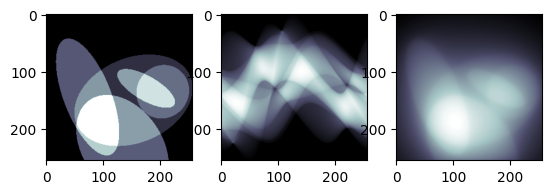

In [5]:
# Visualizing the trainning set
fig, axes = plt.subplots(1,3)
axes[0].imshow(trainning_phantom[1], cmap = 'bone')
axes[1].imshow(trainning_sinogram[1].T, cmap = 'bone')
axes[2].imshow(back_proj(trainning_sinogram[1]), cmap = 'bone')

In [ ]:
# Convert data to PyTorch tensors
phantom_tensor = torch.tensor(trainning_phantom)
sinogram_tensor = torch.tensor(trainning_sinogram)

In [ ]:
# Create a 5-layer LPD object
LPD_net = LPD(5, 3, forward_proj, back_proj)

In [ ]:
# Move data to VRAM if cuda is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
LPD_net = LPD_net.to(device)

In [ ]:
# Define loss and optimizer
mseloss = nn.MSELoss()
optimizer = torch.optim.Adam(LPD_net.parameters(), lr=1e-5)

In [ ]:
# You can increase batch_size if you have enough VRAM
train_data = []
for i in range(len(phantom_tensor)):
   train_data.append([sinogram_tensor[i][None,...], phantom_tensor[i][None,...]])
trainloader = torch.utils.data.DataLoader(train_data, batch_size=1,
                                          shuffle=True, num_workers=0)

In [ ]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, refs]

        inputs, refs = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward
        outputs = LPD_net(inputs)
        loss = mseloss(outputs.float(), refs.float())
        loss.backward()

        # Gradient clipping to fix exploding gradients
        # nn.utils.clip_grad_norm_(LPD_net.parameters(), 5)

        # optimize
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 50 == 49:    # print every 10 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss/50:.8f}')
            running_loss = 0.0
print('Finished Training')

[1,    50] loss: 0.67586517
[1,   100] loss: 0.34435949
[1,   150] loss: 0.21016185
[1,   200] loss: 0.15229924
[1,   250] loss: 0.12355428
[1,   300] loss: 0.10473121
[1,   350] loss: 0.08088299
[1,   400] loss: 0.07501044
[1,   450] loss: 0.06626219
[1,   500] loss: 0.06460723
[1,   550] loss: 0.05042993
[1,   600] loss: 0.04225084
[1,   650] loss: 0.03834971
[1,   700] loss: 0.03312947
[1,   750] loss: 0.03144716
[1,   800] loss: 0.02968939
[1,   850] loss: 0.02370397
[1,   900] loss: 0.02284644
[1,   950] loss: 0.02253953
[1,  1000] loss: 0.02034130
[1,  1050] loss: 0.01813031
[1,  1100] loss: 0.01730058
[1,  1150] loss: 0.01601740
[1,  1200] loss: 0.01414551
[1,  1250] loss: 0.01298060
[1,  1300] loss: 0.01378062
[1,  1350] loss: 0.01152289
[1,  1400] loss: 0.01216877
[1,  1450] loss: 0.01091957
[1,  1500] loss: 0.01045601
[1,  1550] loss: 0.01063726
[1,  1600] loss: 0.00955101
[1,  1650] loss: 0.00897537
[1,  1700] loss: 0.00858251
[1,  1750] loss: 0.00852422
[1,  1800] loss: 0.0

In [ ]:
LPD_net = LPD_net.cpu()
torch.save(LPD_net.state_dict(), "LPD_5_256_512_10000_1epoch.pth")